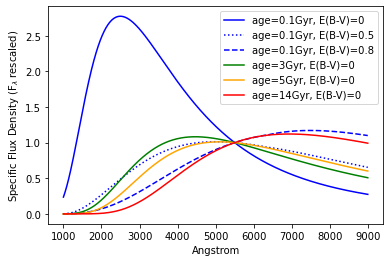

In [3]:
# this is a simple example of a python script to generate and plot
# a superposition of stellar spectra assumed as black-bodies
#
# author: SC
# last revision: April 04, 2023
#

import numpy as np
import matplotlib.pyplot as plt

from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy import constants as const

plt.figure()

# set global parameters:
temp_sun = 5780.0*u.K

# initialize wavelength array
wav = np.arange(1000, 10000) * u.AA
 
# build mass range (linear)
minmass = 0.1 #0.1 # linear
maxmass = 100 
nbins = 1000  # it is important to have a large number of bins for a proper sampling 
              # if using linear range
dm = (maxmass-minmass)/np.float(nbins)
massbins = np.linspace(minmass, maxmass, num=nbins)

# dust attenuation law (Calzetti+2000, starburst galaxies):
def dust_att_k(wav):
    wav_um = wav/u.um
    k1 = 2.659*(-2.156+1.509/wav_um-0.198/(wav_um**2)+0.011/(wav_um**3))+4.05
    k2 = 2.659*(-1.857+1.040/wav_um)+4.03 # 4.03 instead of 4.05 avoids sudden jump at 0.63um 
    k = np.where(wav_um<=0.63, k1, k2)
    return k
    
# simple stellar population model
def SSP(wav, SSP_age, E_B_V = 0):
    # initialize totflux array (code units)
    totflux=0. 
    #loop over masses
    for mass in massbins:
        L = mass**3.5 # units L_sun (code units)
        age = mass/L*10. # Gyr
        if SSP_age<=age:
            if mass<2 :
                n = 4
            else:
                n = 18
            r = mass**((n-1)/(n+3)) # solar units
            T = (L/(r**2))**(1/4)*temp_sun  # units u.K
            nstars = mass**(-2.35)  # Salpeter IMF (code units)
            #get bb spectrum (per unit AA) at this temperature, to be renormalized to the bolometric value 
            bb = BlackBody(temperature=T, scale=1. * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
            flux = nstars*L*(bb(wav).value/bb.bolometric_flux.value) # NB: bolometric_flux is in units of erg/cm^2/s
            totflux = totflux + flux
    # attenuate by dust
    k = dust_att_k(wav)
    totflux = totflux * 10**(-0.4*k*E_B_V)
    return totflux


# plot a given SED
def plotSSP(wav, SSP_age, E_B_V=0, normwav=5500*u.AA, lstyle="-", col="blue"):
    totflux=SSP(wav, SSP_age, E_B_V)
    # normalize at 5500AA
    totflux_norm = totflux/totflux[wav==normwav]
    # plot SED
    plt.plot(wav, totflux_norm, label="age="+str(SSP_age)+"Gyr"", E(B-V)="+str(E_B_V), linestyle=lstyle, color=col)
    return 

# initialize wavelength array
wav = np.arange(1000, 9000) * u.AA
 
# plot various SEDs
plotSSP(wav, SSP_age=0.1, E_B_V=0, col="blue")
plotSSP(wav, SSP_age=0.1, E_B_V=0.5, lstyle=":", col="blue")
plotSSP(wav, SSP_age=0.1, E_B_V=0.8, lstyle="--", col="blue")
plotSSP(wav, SSP_age=3, col="green")
plotSSP(wav, SSP_age=5, col="orange")
plotSSP(wav, SSP_age=14, col="red")


plt.xlabel("Angstrom")
plt.ylabel("Specific Flux Density (F$_{\lambda}$ rescaled)")
plt.legend(loc="upper right")
plt.show()



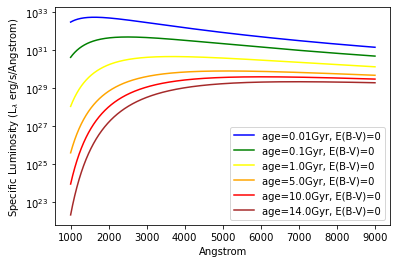

In [4]:
# convert SSP SED to units of erg/s/AA and for a total initial mass of 1 solar masses 
def SSP_CGS(wav, SSP_age, E_B_V):
    salpeter_norm=((maxmass**(-0.35))-(minmass**(-0.35)))/(-0.35) # integral of M*IMF(M)dM
    # original SSP units (code units): L_sun/sr/AA
    SSP_CGS=SSP(wav, SSP_age, E_B_V)*4.*np.pi*(dm/salpeter_norm)*const.L_sun.to(u.erg/u.s) # 4pi needed to remove sr^-1
    # SSP_CGS units: erg/s/AA (per 1 solar masses of total intial mass)
    return SSP_CGS


# plot a given SED in units of erg/s/AA and total initial mass of TotMass in solar units
def plotSSP_CGS(wav, SSP_age, E_B_V=0, TotMass=1.0, logplot=False, lstyle="-", col="blue"):
    totflux=SSP_CGS(wav, SSP_age, E_B_V) # units: erg/s/AA
    # normalize by TotMass
    totflux_norm = totflux*TotMass 
    if(logplot): 
        plt.yscale('log')
    else:
        plt.yscale('linear')   
    # plot SED
    plt.plot(wav, totflux_norm, label="age="+str(SSP_age)+"Gyr"", E(B-V)="+str(E_B_V), linestyle=lstyle, color=col)
    return 


# plot various SEDs
plotSSP_CGS(wav, SSP_age=0.01, E_B_V=0, TotMass=1.0, col="blue", logplot=True)
plotSSP_CGS(wav, SSP_age=0.1, E_B_V=0, TotMass=1.0, col="green", logplot=True)
plotSSP_CGS(wav, SSP_age=1.0, E_B_V=0, TotMass=1.0, col="yellow", logplot=True)
plotSSP_CGS(wav, SSP_age=5.0, E_B_V=0, TotMass=1.0, col="orange", logplot=True)
plotSSP_CGS(wav, SSP_age=10.0, E_B_V=0, TotMass=1.0, col="red", logplot=True)
plotSSP_CGS(wav, SSP_age=14.0, E_B_V=0, TotMass=1.0, col="brown", logplot=True)


plt.xlabel("Angstrom")
plt.ylabel("Specific Luminosity (L$_{\lambda}$ erg/s/Angstrom)")
plt.legend(loc="lower right")
plt.show()



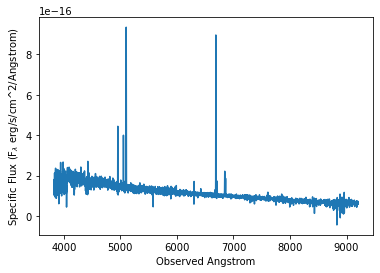

In [5]:
# open and read FITS spectrum (FITS table format)

from astropy.io import fits as fits
path = "/Users/cantal/Data/Teaching/LAB23_Spectra_IntroActivities/"
spc_S1 = fits.open(path+"S1.fits")

# read first extension
data_S1 = spc_S1[1].data
flux_S1 = data_S1['flux']*1.e-17*u.erg/u.s/(u.cm**2)/u.AA # convert to cgs
lam_S1 = 10**data_S1['loglam']*u.AA

plt.plot(lam_S1, flux_S1)
plt.xlabel("Observed Angstrom")
plt.ylabel("Specific Flux (F$_{\lambda}$ erg/s/cm^2/Angstrom)")
plt.show()


2.6099379858414696e+26 cm 84.58232971249176 Mpc


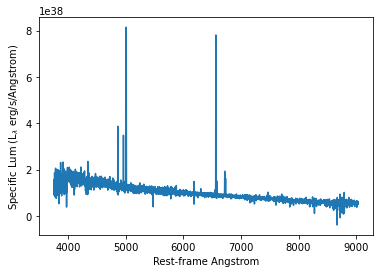

In [6]:
# convert observed flux to specific luminosity
# a cosmology is needed
from astropy.cosmology import Planck13 as cosmo
# a redshift is needed
z_S1 = 0.01884919

dist = cosmo.luminosity_distance(z_S1).to(u.cm)
print(dist, cosmo.luminosity_distance(z_S1))
lum_S1 = 4.*np.pi*(dist**2)*flux_S1*(1+z_S1) # *(1+z) needed because it is a specific lum (i.e. per unit AA)
rf_lam_S1 = lam_S1/(1+z_S1)

plt.plot(rf_lam_S1, lum_S1)
plt.xlabel("Rest-frame Angstrom")
plt.ylabel("Specific Lum (L$_{\lambda}$ erg/s/Angstrom)")
plt.show()

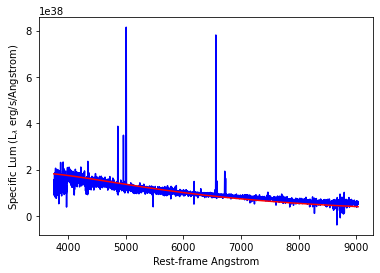

In [20]:
# compare data and model
Mass = 2e7
Age = 0.5
model_S1 = SSP_CGS(rf_lam_S1, SSP_age=Age, E_B_V=0.0)*Mass

plt.plot(rf_lam_S1, lum_S1, color='blue')
plt.plot(rf_lam_S1, model_S1, color='red')
plt.xlabel("Rest-frame Angstrom")
plt.ylabel("Specific Lum (L$_{\lambda}$ erg/s/Angstrom)")
plt.show()

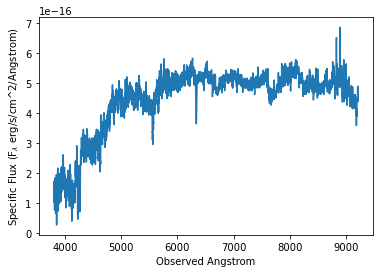

In [8]:
# try another one

spc = fits.open(path+"S4.fits")

# read first extension
data = spc[1].data
flux = data['flux']*1.e-17*u.erg/u.s/(u.cm**2)/u.AA # convert to cgs
lam = 10**data['loglam']*u.AA

plt.plot(lam, flux)
plt.xlabel("Observed Angstrom")
plt.ylabel("Specific Flux (F$_{\lambda}$ erg/s/cm^2/Angstrom)")
plt.show()


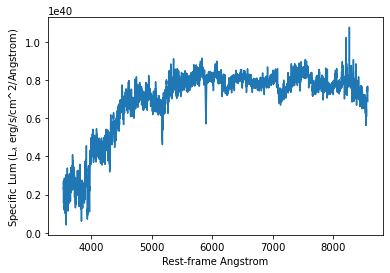

In [9]:
z = 0.07477554

dist = cosmo.luminosity_distance(z).to(u.cm)
lum = 4.*np.pi*(dist**2)*flux*(1+z) # 1/(1+z) needed because it is a specific lum (i.e. per unit AA)
rf_lam = lam/(1+z)

plt.plot(rf_lam, lum)
plt.xlabel("Rest-frame Angstrom")
plt.ylabel("Specific Lum (L$_{\lambda}$ erg/s/Angstrom)")
plt.show()

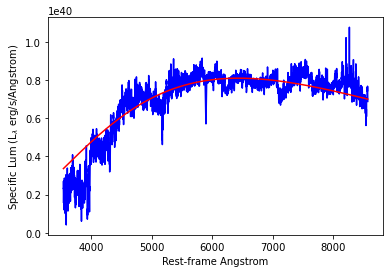

In [24]:
# compare data and model
Mass = 2.7e10
Age = 12.0
model = SSP_CGS(rf_lam, SSP_age=Age, E_B_V=0)*Mass

plt.plot(rf_lam, lum, color='blue')
plt.plot(rf_lam, model, color='red')
plt.xlabel("Rest-frame Angstrom")
plt.ylabel("Specific Lum (L$_{\lambda}$ erg/s/Angstrom)")
plt.show()

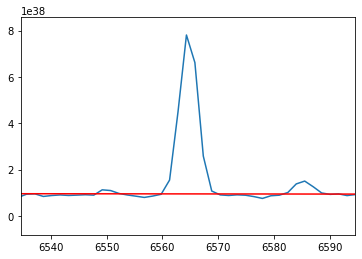

In [11]:
# calculate SFR for S1

# zoom-in on H-alpha region
Ha_lam_rf = 6564.6
plt.xlim(Ha_lam_rf-30, Ha_lam_rf+30)
plt.plot(rf_lam_S1, lum_S1)
plt.plot(rf_lam_S1, model_S1, color="red")
plt.show()



In [12]:

# find binsize in AA
binsize_AA = rf_lam_S1[1] - rf_lam_S1[0]

# sum H-alpha
Lum_Ha = np.sum(lum_S1[np.logical_and(rf_lam_S1>6550*u.AA, rf_lam_S1<6580*u.AA)]- \
         model_S1.value[np.logical_and(rf_lam_S1>6550*u.AA, rf_lam_S1<6580*u.AA)]*u.erg/u.s/u.AA)*binsize_AA

print(Lum_Ha)

# convert to photons
Ha_en = (const.h.to(u.erg*u.s)*const.c.to(u.AA/u.s)/(Ha_lam_rf*u.AA))
print(Ha_en)
Lum_Ha_phot = Lum_Ha/Ha_en

print(Lum_Ha_phot)

# fraction of recombinations producing Ha photons
f_Ha=0.45 

# this is thus the value of Q(H+):
Q_Hplus=Lum_Ha_phot/f_Ha

print(Q_Hplus)

# Approx SFR to Q_Hplus relation (from Sternberg et al. 2003) for continuous SFR:
SFR = Q_Hplus*1.e-53*u.s # per 1 M_sun/yr of SFR

print(SFR, "M_sun/yr")


1.5195759972210817e+39 erg / s
3.025996796680572e-12 erg
5.021736965776075e+50 1 / s
1.115941547950239e+51 1 / s
0.01115941547950239 M_sun/yr
